In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Data Preprocess
## 1. Merge

In [ ]:
import os

dir_name = 'taxi_log_2008_by_id/'
file_list = os.listdir(dir_name)
file_list.sort(key=lambda x:int(x[:-4]))

for i, f in enumerate(file_list):
    if not i%100:
        print(i)
    df = (pd.read_csv(dir_name + f, names=['taxi_id', 'date_time', 'longitude', 'latitude']))
    df.to_csv('all.txt', mode="a+", index=False, header=None)

## 2. Filter

In [4]:
df = pd.read_csv('all.txt', 
    header=None, 
    names=['taxi_id', 'date_time', 'longitude', 'latitude'], 
    dtype={'taxi_id':int, 'date_time':object, 'longitude':float, 'latitude':float}, 
    parse_dates=['date_time'], 
    infer_datetime_format=True)
df.tail(5)

,taxi_id,date_time,longitude,latitude
17662979,10357,2008-02-08 17:26:51,116.72877,40.01143
17662980,10357,2008-02-08 17:26:51,116.72877,40.01143
17662981,10357,2008-02-08 17:26:51,116.72877,40.01143
17662982,10357,2008-02-08 17:26:51,116.72877,40.01143
17662983,10357,2008-02-08 17:26:51,116.72877,40.01143


In [5]:
import folium
from folium.plugins import HeatMap

center = [df['latitude'].mean(), df['longitude'].mean()]

m = folium.Map(center, zoom_start=12)

# latitude_min = 39.81
# longitude_min = 116.245
# latitude_step = 0.0045 # 500m
# longitude_step = 0.0058 # 495m
# latitude_num = 50
# longitude_num = 50

latitude_min = 39.81
longitude_min = 116.245
latitude_step = 0.0075 # 
longitude_step = 0.0100 # 
latitude_num = 30
longitude_num = 30

latitude_max = latitude_min + latitude_num*latitude_step
longitude_max = longitude_min + longitude_num*longitude_step

locations = [[latitude_min, longitude_min], [latitude_min, longitude_max],
            [latitude_max, longitude_max], [latitude_max, longitude_min],
            [latitude_min, longitude_min]]

folium.PolyLine(
    locations, # 坐标点列表
    weight=2, # 线宽
    color='black', # 线条颜色
    opacity=0.8 # 透明度
).add_to(m)

polygons = []
for i in range(latitude_num):
    latitude_right = latitude_min + latitude_step * (i+1)
    polygons.append([[latitude_right, longitude_min], [latitude_right, longitude_max]])

for i in range(longitude_num):
    longitude_down  = longitude_min + longitude_step * (i+1)
    polygons.append([[latitude_min, longitude_down], [latitude_max, longitude_down]])

folium.PolyLine(
    polygons, # 坐标点列表
    weight=1, # 线宽
    color='black', # 线条颜色
    opacity=0.8 # 透明度
).add_to(m)

interval = pd.Timedelta('1min')
start = pd.Timestamp('2008-02-02 13:30:00') + interval
df_locations = df.loc[(df['date_time'] > start) & (df['date_time'] < start + pd.Timedelta(interval))]

for _, row in df_locations.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=1,
                        fill_color="#3db7e4", 
                    ).add_to(m)
    
points = df_locations[['latitude', 'longitude']].values
m.add_child(HeatMap(points, radius=15)) # plot heatmap

m

In [35]:
df_grid = df.drop(df[(df['latitude'] < latitude_min) | (df['latitude'] > latitude_max) | (df['longitude'] < longitude_min) | (df['longitude'] > longitude_max)].index).reset_index(drop=True)
df_grid['location_id'] = df_grid.apply(lambda row : longitude_num*int((row['latitude'] - latitude_min)/latitude_step) + int((row['longitude'] - longitude_min)/longitude_step), axis=1)
df_grid.head(5) 

,taxi_id,date_time,longitude,latitude,location_id
0,1,2008-02-02 15:36:08,116.51172,39.92123,446
1,1,2008-02-02 15:46:08,116.51135,39.93883,536
2,1,2008-02-02 15:46:08,116.51135,39.93883,536
3,1,2008-02-02 15:56:08,116.51627,39.91034,417
4,1,2008-02-02 16:06:08,116.47186,39.91248,412


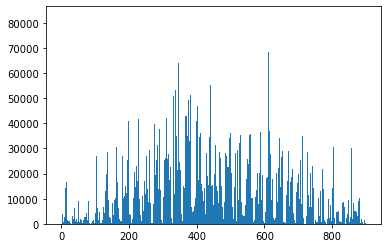

In [12]:
plt.hist(df_grid['location_id'], latitude_num*longitude_num)
plt.show()

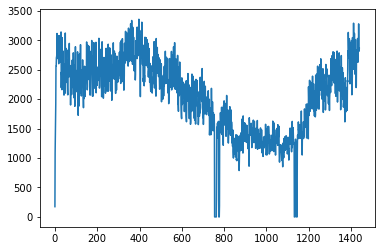

In [14]:
current_time = pd.Timestamp('2008-02-02 13:30:00')
interval = '1min'
point_num = []
for i in range(1440): # 24 hour
    point_num.append(len(df.loc[(df['date_time'] > current_time) & (df['date_time'] < current_time + pd.Timedelta(interval))]))
    current_time += pd.Timedelta(interval)
plt.plot(point_num)
plt.show()

In [37]:
day_df = df_grid.loc[df_grid['date_time'] < start + pd.Timedelta('1day')].reset_index(drop=True)
day_df = day_df.groupby([pd.Grouper(key='date_time', freq='1min'), 'taxi_id']).first().reset_index()
day_df.head(5)

,date_time,taxi_id,longitude,latitude,location_id
0,2008-02-02 13:30:00,366,116.45353,39.90732,380
1,2008-02-02 13:30:00,719,116.34647,40.00016,760
2,2008-02-02 13:30:00,875,116.30687,40.02802,876
3,2008-02-02 13:30:00,877,116.26838,39.90653,362
4,2008-02-02 13:30:00,950,116.29443,39.88372,274


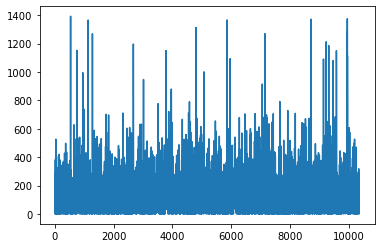

In [54]:
timestamp_num = []
for i in range(1, 10357): # 24 hour
    timestamp_num.append(len(cor_df.loc[cor_df['taxi_id']==i]))
plt.plot(timestamp_num)
plt.show()

In [38]:
from geopy.distance import geodesic

day_df['x'] = day_df.apply(lambda row: geodesic((row['latitude'], longitude_min), (row['latitude'], row['longitude'])).m, axis=1)
day_df['y'] = day_df.apply(lambda row: geodesic((latitude_min, row['longitude']), (row['latitude'], row['longitude'])).m, axis=1)

In [42]:
day_df.drop('latitude', axis=1, inplace=True)
day_df.drop('longitude', axis=1, inplace=True)
day_df.head(10)

,date_time,taxi_id,location_id,x,y
0,2008-02-02 13:30:00,366,380,17831.228067,10805.626231
1,2008-02-02 13:30:00,719,760,8664.893974,21113.999002
2,2008-02-02 13:30:00,875,876,5281.157698,24207.431410
3,2008-02-02 13:30:00,877,362,1999.227901,10717.910284
4,2008-02-02 13:30:00,950,274,4228.169328,8185.256271
5,2008-02-02 13:30:00,1131,231,18226.826473,6631.914890
6,2008-02-02 13:30:00,1277,336,5911.493386,9386.627950
7,2008-02-02 13:30:00,1389,370,9098.389296,10627.973692
8,2008-02-02 13:30:00,1557,639,8299.349475,18033.905603
9,2008-02-02 13:30:00,1578,291,18530.629684,7657.852593


In [21]:
day_df.to_csv('xy_day.csv', index=None)

In [41]:
coordinate = np.zeros((latitude_num*longitude_num, 3))
for i in range(latitude_num*longitude_num):
    coordinate[i][0] = i
    latitude = latitude_min + latitude_step*int(i/longitude_num) + latitude_step/2
    longitude = longitude_min + longitude_step*(i%longitude_num) + longitude_step/2
    coordinate[i][1] = geodesic((latitude, longitude), (latitude, longitude_min)).m
    coordinate[i][2] = geodesic((latitude, longitude), (latitude_min, longitude)).m

loc_df = pd.DataFrame(coordinate, columns=['location_id', 'x', 'y'])
loc_df.head(31)

,location_id,x,y
0,0.0,428.127048,416.366323
1,1.0,1284.381143,416.366323
2,2.0,2140.635234,416.366323
3,3.0,2996.889318,416.366323
4,4.0,3853.143393,416.366323
5,5.0,4709.397456,416.366323
6,6.0,5565.651504,416.366323
7,7.0,6421.905535,416.366323
8,8.0,7278.159545,416.366323
9,9.0,8134.413533,416.366323


In [32]:
loc_df.to_csv('xy_loc.csv', index=None)

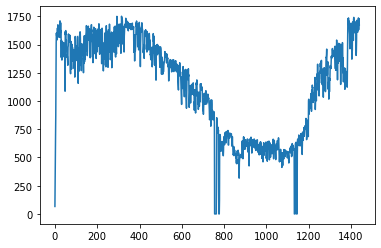

In [33]:
current_time = pd.Timestamp('2008-02-02 13:30:00')
interval = '1min'
taxi_num = []
for i in range(1440): # 24 hour
    taxi_num.append(len(day_df.loc[day_df['date_time']==current_time]))
    current_time += pd.Timedelta(interval)
plt.plot(taxi_num)
plt.show()

In [34]:
taxi_num = np.array(taxi_num)
print(taxi_num.mean())
print(taxi_num.min())
print(len(taxi_num[taxi_num==0]))
print(taxi_num[0:20])

1127.4354166666667
0
20
[  66  316  546  691  869 1220 1515 1602 1576 1575 1541 1612 1646 1608
 1675 1576 1633 1664 1615 1651]
